# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

from ml.visualization import plot_learning_curve

np.random.seed(0)  # Para mayor determinismo


In [70]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [71]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
dataset.shape

(1854, 11)

In [72]:
dataset.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [73]:
dataset[dataset['TARGET'] == 1].shape


(309, 11)

In [74]:
dataset[dataset['TARGET'] == 0].shape


(1545, 11)

In [75]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
# test_zize = 0.2 es el 20% de los datos reservados para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:



1. ¿De qué se trata el conjunto de datos?


El dataset contiene datos de solicitudes de creditos para un determinada entidad bancaria.
El objetivo es predicir/automatizar la decisión sobre si una solicitud futura debe ser aceptada o rechazada.

2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?


El feature TARGET, que toma valores 1 o 0  en los siguientes casos:

1 = el cliente incumplió con el préstamo   
0 = el préstamo se pagó

3. ¿Qué información (atributos) hay disponible para hacer la predicción?


 Ademas del feature TARGET contamos con los siguientes datos:  
 
 
     LOAN:    Cantidad de dinero solicitado.   
     MORTDUE: Monto a pagar de la hipoteca existente.     
     VALUE:   Valor de la propiedad actual.     
     YOJ:     Años de antiguedad en el trabajo actual.    
     DEROG:   Número de informes derogados principales.     
     DELINQ:   Número de líneas de crédito morosas.     
     CLAGE:   Edad de la línea comercial más antigua en meses.
     NINQ:    Número de líneas de crédito recientes    
     CLNO:    Número de líneas de crédito     
     DEBTINC: Relación deuda / ingresos.  
 

4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?


LOAN: El monto solicitado es determinante, pues deben haber rangos de creditos dependiendo de las condiciones que cumple el solicitante.     

DEBTINC: Es crucial saber si el solicitante tiene capacidad para afrontar el pago de las cuotas del credito.    

MORTDUEL Parece ser un feature importante, creo que indica el monto restante a pagar para prestamos activos.  

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [76]:
m = SGDClassifier(random_state=42)
m.fit(X_train, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [77]:
print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, m.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       313
           1       0.00      0.00      0.00        58

    accuracy                           0.84       371
   macro avg       0.42      0.50      0.46       371
weighted avg       0.71      0.84      0.77       371




/Users/luisvargas/code/migue/github/diplo/2019/diplo_venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


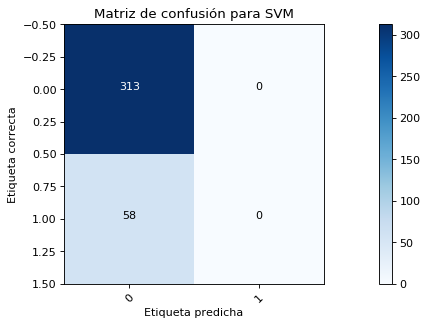

In [78]:
plt.figure(figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], title="Matriz de confusión para SVM")

Sin ajuste de hiperparámetros se evidencia que el clasificador lineal de SGD usando SVM como funcion de costo, no ajusta bien para los casos en que TARGET es 1. De hecho el se clasifican a todos los casos 1 como 0.

In [79]:
X_train.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1240,9400,92340.0,125451.0,7.0,0.0,0.0,129.113725,1.0,22.0,36.349975
1183,14800,43983.0,60826.0,4.0,1.0,1.0,113.897967,1.0,9.0,27.108082
692,20100,59726.0,79982.0,8.0,1.0,0.0,74.210759,2.0,28.0,36.846922
871,25200,73168.0,93608.0,9.0,0.0,0.0,151.121480,0.0,21.0,35.590327
1353,17000,70039.0,100993.0,7.0,0.0,0.0,261.911317,1.0,11.0,36.564330


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

/Users/luisvargas/code/migue/github/diplo/2019/diplo_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros para función de coste "hinge"

Mejor conjunto de parámetros:
{'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.694 (+/-0.069) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.830 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.567 (+/-0.104) para los parámetros {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.699 (+/-0.070) para los parámetros {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.696 (+/-0.069) para los parámetros {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.541 (+/-0.094) para los parámetros {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.683 (+/-0.066) para los parámetros {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.695 (+/-0.069) para los parámetros {'alpha': 0.001, 'eta0': 0.01

/Users/luisvargas/code/migue/github/diplo/2019/diplo_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.766 (+/-0.017) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.827 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.701 (+/-0.068) para los parámetros {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.799 (+/-0.004) para los parámetros {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.560 (+/-0.102) para los parámetros {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.765 (+/-0.016) para los parámetros {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.699 (+/-0.069) para los parámetros {'alpha': 0.001, 'eta0': 0.01

/Users/luisvargas/code/migue/github/diplo/2019/diplo_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros para función de coste "perceptron"

Mejor conjunto de parámetros:
{'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.824 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.829 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.702 (+/-0.053) para los parámetros {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.670 (+/-0.066) para los parámetros {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.682 (+/-0.066) para los parámetros {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.827 (+/-0.000) para los parámetros {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.564 (+/-0.095) para los parámetros {'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'constant'}
Exactitud: 0.710 (+/-0.058) para los parámetros {'alpha': 0.001, 'eta0':

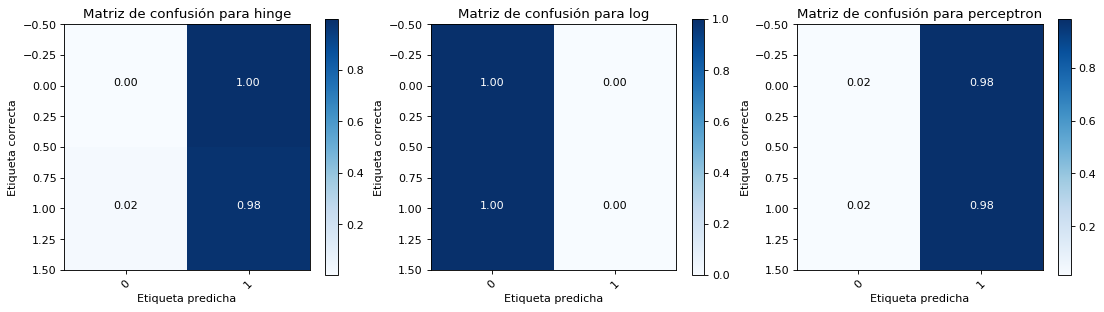

In [80]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

for idx, loss in enumerate(('hinge', 'log', 'perceptron'), start=1):
    exploring_params = {
        'learning_rate': ['constant'],
        'eta0': [0.1, 0.01, 0.001],  # Tasa de entrenamiento
        'alpha': [0.1, 0.01, 0.001]  # Tasa de regularización
    }
    cl = SGDClassifier(loss=loss, tol=1e-3)
    model = GridSearchCV(cl, exploring_params, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")

    plt.subplot(1, 3, idx)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=['0','1'], normalize=True, title="Matriz de confusión para %s" % loss)

## Ejercicio 3: Árbol de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.62      0.62        58

    accuracy                           0.88       371
   macro avg       0.78      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371





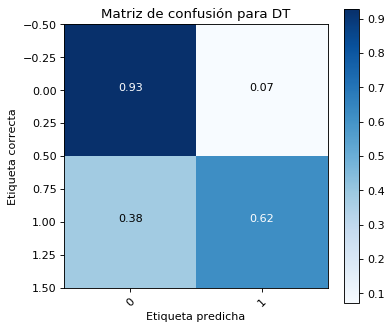

In [81]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

plt.subplot(1, 3, idx)
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=[0, 1], normalize=True, title="Matriz de confusión para DT")

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Exploración de hiperparámetros para función de coste "perceptron"

Mejor conjunto de parámetros:
{'criterion': 'gini', 'max_depth': 9, 'max_features': 8, 'max_leaf_nodes': 30, 'min_samples_leaf': 15, 'min_samples_split': 200}

Puntajes de la grilla:

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       313
           1       0.63      0.41      0.50        58

    accuracy                           0.87       371
   macro avg       0.76      0.68      0.71       371
weighted avg       0.86      0.87      0.86       371





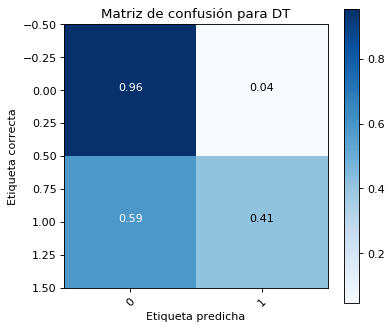

In [95]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
from sklearn.tree import DecisionTreeClassifier
 #96-04 /  59-41
exploring_params = {
                'criterion':('gini', 'entropy'), 
                'min_samples_leaf':(8, 10, 15),
                'min_samples_split':(200, 790, 900),
                'max_leaf_nodes':(15, 20, 30),
                'max_depth': (9, 10, 11),
                'max_features': (3, 5, 8),
               }


exploring_params2 = {
                'criterion':('gini', 'entropy'), 
                'min_samples_leaf':(8, 10, 15),
                'min_samples_split':(200, 790, 900),
                'max_leaf_nodes':(15, 20, 30),
                'max_depth': (9, 10, 11, 12),
                'max_features': (3, 5, 8, 9),
               }


cl = DecisionTreeClassifier()
model = GridSearchCV(cl, exploring_params2, cv=5, scoring='accuracy')
model.fit(X_train, y_train)

print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, model.cv_results_['params']):
    #print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
#print()

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

plt.subplot(1, 3, idx)
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=['0','1'], normalize=True, title="Matriz de confusión para DT")